In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import packages
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import os
import cv2
import glob
import seaborn as sns

import matplotlib.pyplot as plt

# import the necessary packages
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/ASL_Dataset/Train'
TEST_DIR = '/content/drive/MyDrive/ASL_Dataset/new_test_images'

In [4]:
# Load all the images under each class (subdirectory)
def load_images(base_dir, directories_as_labels=True, files='**/*.jpg'):
  filenames = glob.glob(os.path.join(base_dir, files))

  # Load all the subdirectories as classes
  classes = (os.path.basename(os.path.dirname(name)) for name in filenames)
  df = pd.DataFrame(list(zip(filenames, classes)), columns=['path', 'label'])

  return df

train_df = load_images(TRAIN_DIR)
test_df = load_images(TEST_DIR)

In [5]:
batch_size = 64
image_size = 64
num_class = len(train_df['label'].unique())

In [6]:
# save the model
vgg16_1 = tf.keras.models.load_model('/content/drive/MyDrive/ASL_Dataset/vgg16-1-final.h5')
cnn4 = tf.keras.models.load_model('/content/drive/MyDrive/ASL_Dataset/cnn-4-final.h5')
res = tf.keras.models.load_model('/content/drive/MyDrive/ASL_Dataset/res-b2.h5')

In [7]:
from skimage.filters import sobel, scharr
import cv2

def preprocess_image(image):
    '''Function that will be implied on each input. The function
    will run after the image is resized and augmented.
    The function should take one argument: one image (Numpy tensor
    with rank 3), and should output a Numpy tensor with the same
    shape.'''
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    return sobely

### **CNN Predictions**

In [8]:
# X_testing data from a directory
# Sub-directory in that directory will be used as a class for each object
cnn_test_datagen = ImageDataGenerator( samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   horizontal_flip=False,
                                   preprocessing_function=preprocess_image)
cnn_test_generator = cnn_test_datagen.flow_from_directory(
                        directory=TEST_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=False)
y_true = cnn_test_generator.classes

Found 112 images belonging to 28 classes.


In [9]:
%time
cnn_predictions = cnn4.predict(cnn_test_generator)
y_pred_cnn = np.argmax(cnn_predictions, axis = 1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


In [10]:
#get classification report
print(classification_report(y_pred_cnn,y_true))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.40      0.57        10
           2       0.25      1.00      0.40         1
           3       0.00      0.00      0.00         1
           4       0.50      0.25      0.33         8
           5       0.00      0.00      0.00         0
           6       0.75      0.43      0.55         7
           7       0.50      1.00      0.67         2
           8       0.00      0.00      0.00         4
           9       1.00      0.67      0.80         6
          10       0.25      0.17      0.20         6
          11       0.00      0.00      0.00         0
          12       1.00      0.57      0.73         7
          13       0.50      1.00      0.67         2
          14       0.75      0.14      0.24        21
          15       0.25      0.50      0.33         2
          16       0.50      0.67      0.57         3
          17       0.25    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


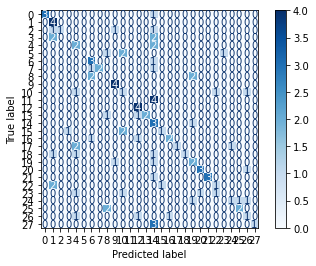

In [11]:
from IPython.core.pylabtools import figsize
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_cnn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
figsize (20,20)
plt.show()

### **Residual Network**

In [12]:
# X_testing data from a directory
# Sub-directory in that directory will be used as a class for each object
res_test_datagen = ImageDataGenerator( samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   horizontal_flip=False,
                                   preprocessing_function=preprocess_image)
res_test_generator = res_test_datagen.flow_from_directory(
                        directory=TEST_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=False)
y_true = res_test_generator.classes

Found 112 images belonging to 28 classes.


In [13]:
%time
resnn_predictions = res.predict(res_test_generator)
y_pred_res = np.argmax(resnn_predictions, axis = 1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


In [14]:
#get classification report
print(classification_report(y_pred_res,y_true))

              precision    recall  f1-score   support

           0       0.25      0.50      0.33         2
           1       0.00      0.00      0.00         0
           2       0.25      1.00      0.40         1
           3       0.50      0.67      0.57         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.75      0.60      0.67         5
           7       0.50      1.00      0.67         2
           8       0.00      0.00      0.00         0
           9       0.75      0.18      0.29        17
          10       0.00      0.00      0.00         1
          11       0.50      1.00      0.67         2
          12       0.50      0.25      0.33         8
          13       1.00      0.50      0.67         8
          14       0.25      0.05      0.08        21
          15       0.25      1.00      0.40         1
          16       0.50      0.67      0.57         3
          17       0.25    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


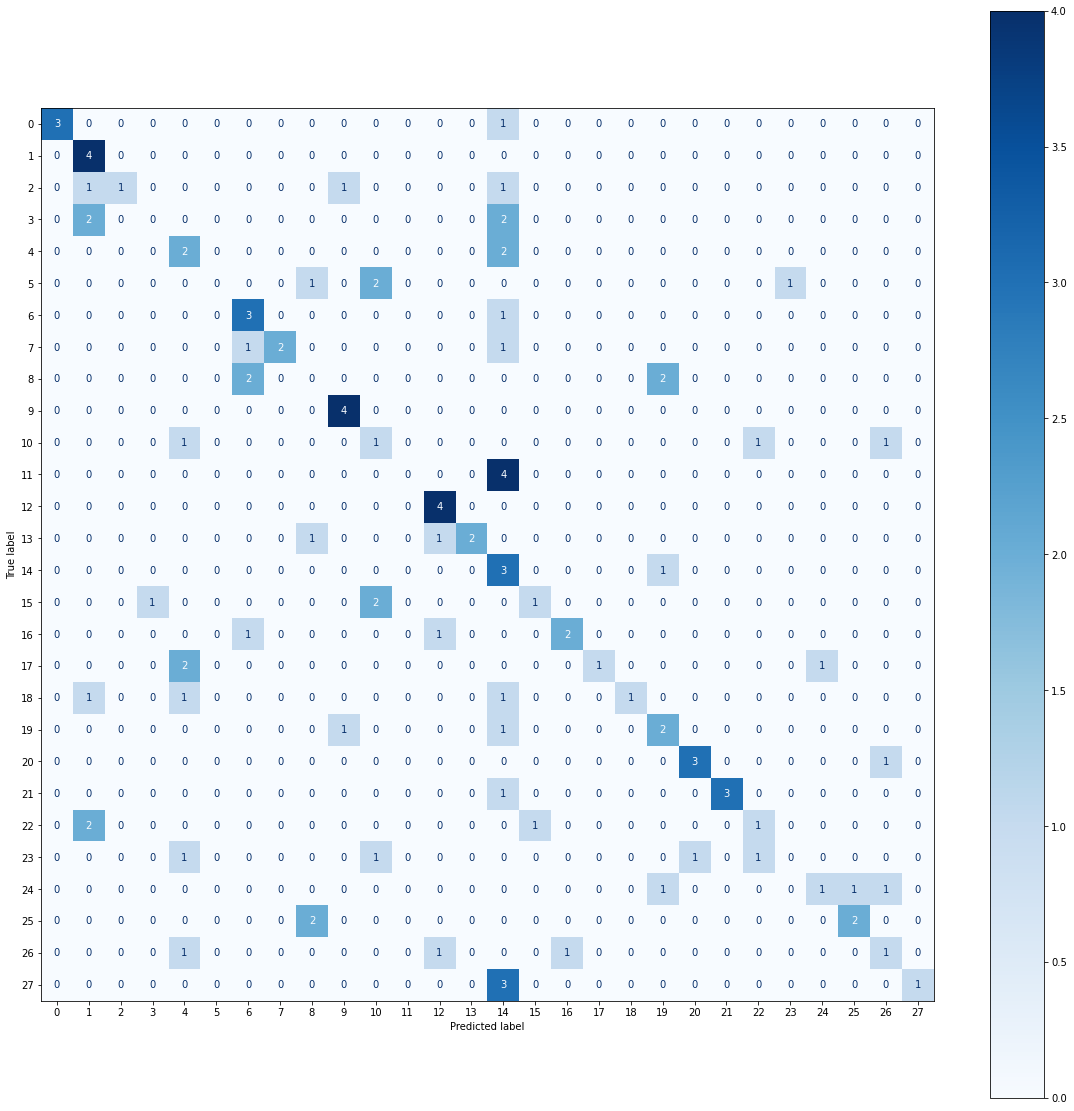

In [15]:
from IPython.core.pylabtools import figsize
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_cnn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
figsize (20,20)
plt.show()

### **VGG16**

In [16]:
# X_testing data from a directory
# Sub-directory in that directory will be used as a class for each object
vgg_test_datagen = ImageDataGenerator()
vgg_test_generator = vgg_test_datagen.flow_from_directory(
                        directory=TEST_DIR,
                        target_size=(image_size,image_size),
                        batch_size=batch_size,
                        class_mode='categorical',
                        color_mode='rgb',
                        shuffle=False)
y_true = vgg_test_generator.classes

Found 112 images belonging to 28 classes.


In [17]:
%time
vgg_predictions = vgg16_1.predict(vgg_test_generator)
y_pred_vgg = np.argmax(vgg_predictions, axis = 1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [18]:
#get classification report
print(classification_report(y_pred_vgg,y_true))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         0
           6       0.50      0.12      0.20        16
           7       0.25      1.00      0.40         1
           8       0.00      0.00      0.00         0
           9       0.75      0.50      0.60         6
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         5
          15       0.50      0.40      0.44         5
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


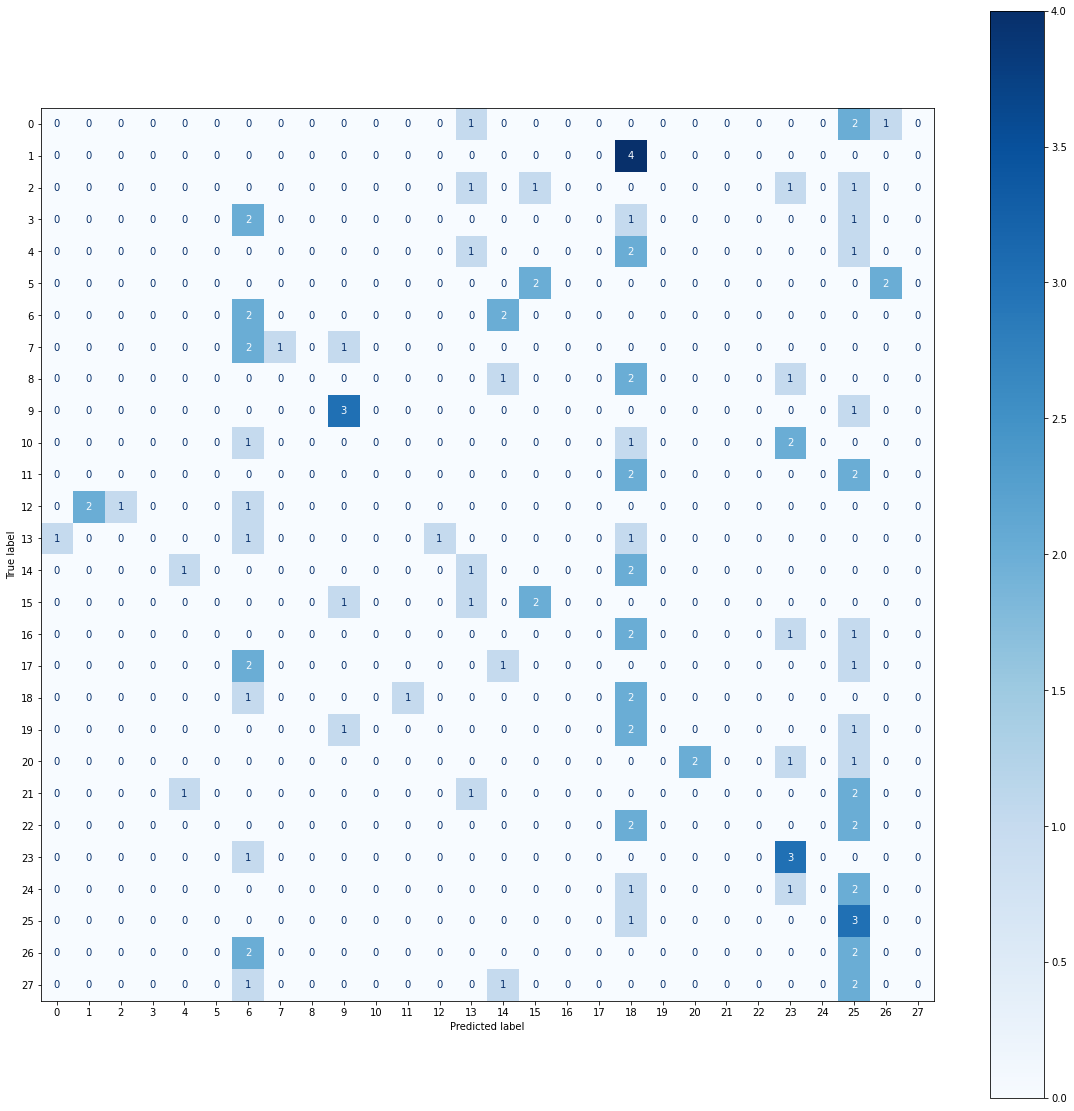

In [19]:
from IPython.core.pylabtools import figsize
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix



cm = confusion_matrix(y_true, y_pred_vgg)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap=plt.cm.Blues)
figsize (60,60)
plt.show()

In [20]:
# save the model
vgg16_1.summary()
cnn4.summary()
res.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 28)                28700     
                                                                 
Total params: 17,891,164
Trainable params: 3,176,476
Non-trainable params: 14,714,688
_________________________________________________________________
Model: "model"
_____________________